### Importación de Librerias

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import plotly.express as px
import seaborn as sns
import toolbox_ML as tb
import warnings

warnings.filterwarnings('ignore')

# Configurar pandas para que no corte las visualizaciones
pd.set_option("display.max_columns", None)  # Mostrar todas las columnas
pd.set_option("display.max_colwidth", None)  # Mostrar todo el contenido de las celdas, si es posible
# pd.set_option('display.max_rows', None) # Mostrar todas las filas

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,TargetEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


### Creando el dataframe

In [3]:
df = pd.read_csv("../data/F1_act.csv")

### Exploración

In [4]:
# Mostrar los primeros 10 registros del dataframe
df.head(10)

,Race,Driver,Constructor,Circuit,Grid,Position_Order,Points,Laps,Fastest_Lap,Rank,Fastest_Lap_Time (Seg),Fastest_Lap_Speed (KM/H),Status,Year,Date
0,European Grand Prix,Jenson Button,Honda,Nurburgring,17,18,0.0,2,2,18,140.0,132.338,Spun Off,2007,22/07/2007
1,European Grand Prix,Adrian Sutil,Spyker,Nurburgring,21,19,0.0,2,2,19,145.8,127.112,Spun Off,2007,22/07/2007
2,European Grand Prix,Nico Rosberg,Williams,Nurburgring,11,20,0.0,2,2,20,170.9,108.410,Spun Off,2007,22/07/2007
3,European Grand Prix,Scott Speed,Toro Rosso,Nurburgring,18,21,0.0,2,2,21,181.9,101.884,Spun Off,2007,22/07/2007
4,European Grand Prix,Vitantonio Liuzzi,Toro Rosso,Nurburgring,19,22,0.0,2,2,22,202.3,91.610,Spun Off,2007,22/07/2007
5,Brazilian Grand Prix,Sakon Yamamoto,Spyker,Interlagos,22,21,0.0,2,2,21,110.4,140.505,Collision,2007,21/10/2007
6,Brazilian Grand Prix,Giancarlo Fisichella,Renault,Interlagos,12,22,0.0,2,2,22,122.7,126.446,Collision,2007,21/10/2007
7,Spanish Grand Prix,Mark Webber,Red Bull,Catalunya,19,21,0.0,7,4,21,86.3,194.131,Hydraulics,2007,13/05/2007
8,Hungarian Grand Prix,Sakon Yamamoto,Spyker,Hungaroring,22,22,0.0,4,4,22,86.7,181.824,Accident,2007,05/08/2007
9,Turkish Grand Prix,Mark Webber,Red Bull,Istanbul,12,22,0.0,9,4,21,90.8,211.620,Hydraulics,2007,26/08/2007


In [5]:
# Mostrar la información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6839 entries, 0 to 6838
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Race                      6839 non-null   object 
 1   Driver                    6839 non-null   object 
 2   Constructor               6839 non-null   object 
 3   Circuit                   6839 non-null   object 
 4   Grid                      6839 non-null   int64  
 5   Position_Order            6839 non-null   int64  
 6   Points                    6839 non-null   float64
 7   Laps                      6839 non-null   int64  
 8   Fastest_Lap               6839 non-null   int64  
 9   Rank                      6839 non-null   int64  
 10  Fastest_Lap_Time (Seg)    6839 non-null   float64
 11  Fastest_Lap_Speed (KM/H)  6839 non-null   float64
 12  Status                    6839 non-null   object 
 13  Year                      6839 non-null   int64  
 14  Date    

In [6]:
df.columns

Index(['Race', 'Driver', 'Constructor', 'Circuit', 'Grid', 'Position_Order',
       'Points', 'Laps', 'Fastest_Lap', 'Rank', 'Fastest_Lap_Time (Seg)',
       'Fastest_Lap_Speed (KM/H)', 'Status', 'Year', 'Date'],
      dtype='object')

### Correlación entre variables

In [7]:
# Tomar todas las columnas del df que contengan tipo de dato numérico
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
correlation_matrix

,Grid,Position_Order,Points,Laps,Fastest_Lap,Rank,Fastest_Lap_Time (Seg),Fastest_Lap_Speed (KM/H),Year
Grid,1.000000,0.589778,-0.597760,-0.103469,-0.057111,0.547656,0.036675,-0.075956,-0.096786
Position_Order,0.589778,1.000000,-0.792167,-0.524463,-0.424649,0.570482,-0.174136,-0.336553,-0.073798
Points,-0.597760,-0.792167,1.000000,0.248350,0.232005,-0.538678,0.066728,0.164408,0.132322
Laps,-0.103469,-0.524463,0.248350,1.000000,0.810019,-0.073243,0.254694,0.504651,0.054212
Fastest_Lap,-0.057111,-0.424649,0.232005,0.810019,1.000000,-0.091930,0.210149,0.455977,0.101223
Rank,0.547656,0.570482,-0.538678,-0.073243,-0.091930,1.000000,0.369899,0.225351,-0.058957
Fastest_Lap_Time (Seg),0.036675,-0.174136,0.066728,0.254694,0.210149,0.369899,1.000000,0.690914,-0.070338
Fastest_Lap_Speed (KM/H),-0.075956,-0.336553,0.164408,0.504651,0.455977,0.225351,0.690914,1.000000,0.088232
Year,-0.096786,-0.073798,0.132322,0.054212,0.101223,-0.058957,-0.070338,0.088232,1.000000


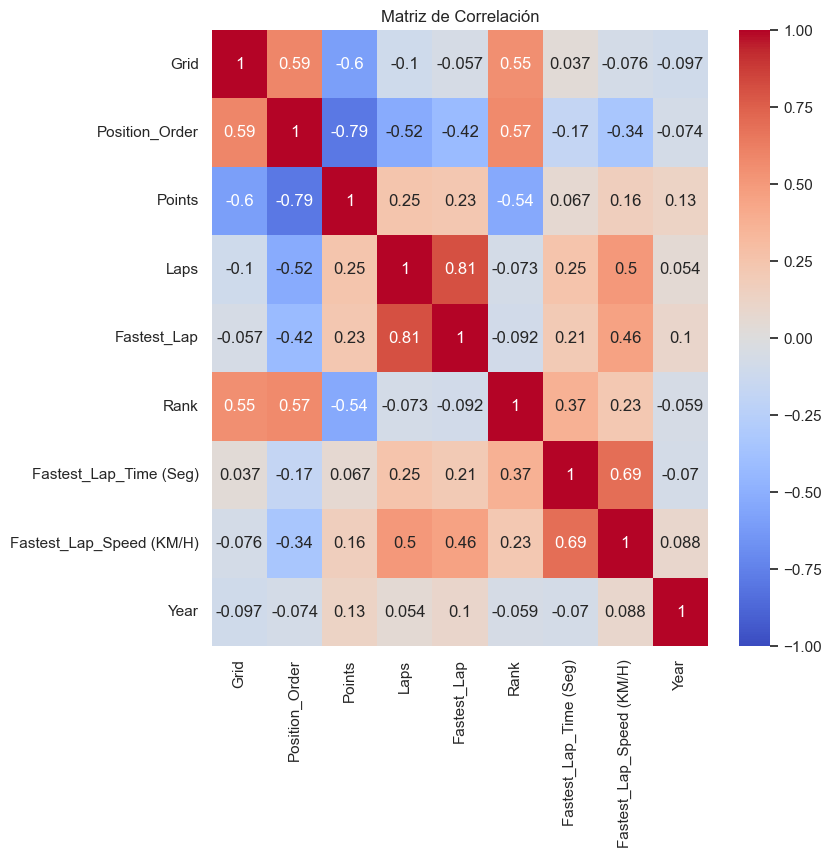

In [8]:
# Configurar el tema a utilizar
sns.set_theme(style="white")

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 8))

# Crear un mapa de calor de la matriz de correlación
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Configurar el título y las etiquetas de los ejes
plt.title('Matriz de Correlación')
plt.show()

### Feature Selection previo a elminacion 

In [9]:
# Preparar datos
target_col = "Position_Order"
X = df.drop(columns=[target_col], axis=1)
y = df[target_col]

# Dividir los datos
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un modelo básico de RandomForest para selección de características
feature_selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')

# Pipeline para preprocesar y seleccionar características
feature_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Entrenar el modelo
feature_pipeline.fit(X_train, y_train)

# Evaluar en el conjunto de validación
val_predictions = feature_pipeline.predict(X_val)
val_acc = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy after feature selection: {val_acc}')

# Evaluar en el conjunto de prueba
test_predictions = feature_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy after feature selection: {test_acc}')

# Obtener las características seleccionadas
selected_features = feature_pipeline.named_steps['feature_selection'].get_support()

# Obtener los nombres de las características después de la transformación
preprocessed_feature_names = list(feature_pipeline.named_steps['preprocessor'].transformers_[0][2]) + \
                             list(feature_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Filtrar las características seleccionadas
selected_feature_names = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if selected_features[i]]
print(f'Selected Features: {selected_feature_names}')


Validation Accuracy after feature selection: 0.385233918128655
Test Accuracy after feature selection: 0.38084795321637427
Selected Features: ['Grid', 'Points', 'Laps', 'Fastest_Lap', 'Rank', 'Fastest_Lap_Time (Seg)', 'Fastest_Lap_Speed (KM/H)', 'Year', 'Race_Abu Dhabi Grand Prix', 'Race_Australian Grand Prix', 'Race_Austrian Grand Prix', 'Race_Azerbaijan Grand Prix', 'Race_Bahrain Grand Prix', 'Race_Belgian Grand Prix', 'Race_Brazilian Grand Prix', 'Race_British Grand Prix', 'Race_Canadian Grand Prix', 'Race_Chinese Grand Prix', 'Race_Dutch Grand Prix', 'Race_Emilia Romagna Grand Prix', 'Race_European Grand Prix', 'Race_French Grand Prix', 'Race_German Grand Prix', 'Race_Hungarian Grand Prix', 'Race_Indian Grand Prix', 'Race_Italian Grand Prix', 'Race_Japanese Grand Prix', 'Race_Korean Grand Prix', 'Race_Malaysian Grand Prix', 'Race_Mexican Grand Prix', 'Race_Mexico City Grand Prix', 'Race_Miami Grand Prix', 'Race_Monaco Grand Prix', 'Race_Portuguese Grand Prix', 'Race_Russian Grand Pr

In [11]:
# Definir el Grid de parámetros para utilizar en GridSearchCV
param_Grid = {
    'classifier__n_estimators': [300, 350, 400],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__bootstrap': [True, False]
}

# Hiperparametrizar el modelo
Grid_search = GridSearchCV(feature_pipeline, param_Grid, cv=5, scoring='accuracy', n_jobs=-1)
Grid_search.fit(X_train, y_train)

print(f'Best parameters: {Grid_search.best_params_}')
print(f'Best cross-validation accuracy: {Grid_search.best_score_}')

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best cross-validation accuracy: 0.40702623213808264


In [12]:
# Utilizar el best_estimator_ para tomar los mejores parámetros del GridSearch y entrenar el modelo con Train
feature_best_model = Grid_search.best_estimator_
feature_best_model.fit(X_train, y_train)

# Evaluar la predicción con el conjunto de validación
val_predictions = feature_best_model.predict(X_val)
val_acc = accuracy_score(y_val, val_predictions)
print(f'Accuracy de validación para el mejor RandomForest: {val_acc}')

Accuracy de validación para el mejor RandomForest: 0.4283625730994152


In [13]:
# Obtener las predicciones contra el Test
test_predictions = feature_best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print(f'Accuracy en Test para el RandomForest tuneado: {test_acc}')

Accuracy en Test para el RandomForest tuneado: 0.4093567251461988


In [14]:
# Guardamos el modelo best_rf_modelo para reutilizarlo
with open('../Models/feature_best_model.pkl', 'wb') as file:
    pickle.dump(feature_best_model, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [8]:
# Eliminar las columnas debido a que son datos que no se conocen al momento de iniciar la carrera
df.drop(columns=['Points', "Fastest_Lap", "Fastest_Lap_Time (Seg)","Fastest_Lap_Speed (KM/H)", "Status"], inplace=True)

### Definición de Target

In [9]:
# Definimos nuestro target
target_col = "Position_Order"
# Separar las características y el target
X = df.drop(columns=[target_col], axis=1) 
y = df[target_col] 

### Train/Validation/Test Split

In [10]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Baseline Dummy Classifier

In [17]:
# Baseline DummyClassifier para comparar con nuestro modelo
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)
print(f'Baseline DummyClassifier Accuracy: {dummy_accuracy}')

Baseline DummyClassifier Accuracy: 0.035818713450292396


### Pipeline con Feature Selection

In [16]:
# Columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un modelo básico de RandomForest para selección de características
feature_selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')

# Pipeline para preprocesar y seleccionar características
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Entrenar el modelo
rf_pipeline.fit(X_train, y_train)

# Evaluar en el conjunto de validación
val_predictions = rf_pipeline.predict(X_val)
val_acc = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy after feature selection: {val_acc}')

# Evaluar en el conjunto de prueba
test_predictions = rf_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy after feature selection: {test_acc}')

# Obtener las características seleccionadas
selected_features = rf_pipeline.named_steps['feature_selection'].get_support()

# Obtener los nombres de las características después de la transformación
preprocessed_feature_names = list(rf_pipeline.named_steps['preprocessor'].transformers_[0][2]) + \
                             list(rf_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Filtrar las características seleccionadas
selected_feature_names = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if selected_features[i]]
print(f'Selected Features: {selected_feature_names}')


Validation Accuracy after feature selection: 0.15789473684210525
Test Accuracy after feature selection: 0.13450292397660818
Selected Features: ['Grid', 'Laps', 'Rank', 'Year', 'Race_Abu Dhabi Grand Prix', 'Race_Australian Grand Prix', 'Race_Austrian Grand Prix', 'Race_Azerbaijan Grand Prix', 'Race_Bahrain Grand Prix', 'Race_Belgian Grand Prix', 'Race_Brazilian Grand Prix', 'Race_British Grand Prix', 'Race_Canadian Grand Prix', 'Race_Chinese Grand Prix', 'Race_Dutch Grand Prix', 'Race_Emilia Romagna Grand Prix', 'Race_European Grand Prix', 'Race_French Grand Prix', 'Race_German Grand Prix', 'Race_Hungarian Grand Prix', 'Race_Indian Grand Prix', 'Race_Italian Grand Prix', 'Race_Japanese Grand Prix', 'Race_Korean Grand Prix', 'Race_Malaysian Grand Prix', 'Race_Mexican Grand Prix', 'Race_Mexico City Grand Prix', 'Race_Miami Grand Prix', 'Race_Monaco Grand Prix', 'Race_Portuguese Grand Prix', 'Race_Russian Grand Prix', 'Race_Saudi Arabian Grand Prix', 'Race_Singapore Grand Prix', 'Race_Span

### Obtención de Features Categoricas

In [18]:
# Lista vacía para almacenar las features categóricas
cat_feature_1 = []
# Seleccionar todas las columnas de nuestro df que corresponden a tipo de dato object y las pasamos a una lista
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    grouped = df.groupby(col)[target_col].apply(list).to_dict()
    feature_values = []
    for key, value in grouped.items():
        # Verificar que la lista no esté vacía y tenga más de un valor único
        if len(value) > 1 and len(set(value)) > 1:
            feature_values.append(value)
    
    if len(feature_values) > 1:  # Asegurar tener más de un grupo para ANOVA
        f_val, p_val = stats.f_oneway(*feature_values)
        if p_val <= 0.05:
            cat_feature_1.append(col)

cat_feature_1

['Driver', 'Constructor']

In [19]:
# Incluir las features categóricas restantes
cat_feature_2 = ['Race', 'Circuit']
cat_feature_2

['Race', 'Circuit']

### Obtención de Features Númericas

In [20]:
# Lista vacía para almacenar las features númericas
num_feature_1 = []

# Seleccionar todas las columnas de nuestro df que corresponden a tipo de dato númericas y las pasamos a una lista
numerical_columns = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16','float32', 'float64']).columns.tolist()

# Eliminar la columna objetivo de la lista de columnas numéricas
numerical_columns.remove(target_col)

# Iterar sobre cada columna numérica
for col in numerical_columns:
    # Calcular la correlación de Pearson entre la columna objetivo y la columna actual
    corr, p_value = pearsonr(df[target_col], df[col])
    
    # Agregar la columna a la lista si cumple con los criterios de correlación y significancia
    if abs(corr) >= 0.3 and p_value <= 0.05:
        num_feature_1.append(col)
        
num_feature_1

['Grid', 'Laps', 'Rank']

### Pipelines de Modelos

In [22]:
# Identificar las columnas categóricas y numéricas
categorical_features = cat_feature_1 + cat_feature_2
numerical_features = num_feature_1

# Preprocesamiento de features numéricas y categóricas
numerical_transformer = StandardScaler()
categorical_transformer = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Crear el pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

lgbm_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("classifier", LGBMClassifier(random_state=42))])

catboost_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                    ("classifier", CatBoostClassifier(random_state=42, silent=True))])


In [24]:
# Obtener los resultados del accuracy de los distintos modelos
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring="accuracy")
lgbm_scores = cross_val_score(lgbm_pipeline, X_train, y_train, cv=5, scoring='accuracy')
catboost_scores = cross_val_score(catboost_pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Obtener la media de los accuracy de cada modelo
print(f'RandomForestClassifier Accuracy: {rf_scores.mean()}')
print(f'LGBMClassifier Accuracy: {lgbm_scores.mean()}')
print(f'CatBoostClassifier Accuracy: {catboost_scores.mean()}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12574
[LightGBM] [Info] Number of data points in the train set: 3282, number of used features: 99
[LightGBM] [Info] Start training from score -2.990263
[LightGBM] [Info] Start training from score -3.119475
[LightGBM] [Info] Start training from score -3.033613
[LightGBM] [Info] Start training from score -3.059256
[LightGBM] [Info] Start training from score -3.072328
[LightGBM] [Info] Start training from score -3.092262
[LightGBM] [Info] Start training from score -2.996342
[LightGBM] [Info] Start training from score -2.954545
[LightGBM] [Info] Start training from score -3.052783
[LightGBM] [Info] Start training from score -3.105776
[LightGBM] [Info] Start training from score -3.126395
[LightGBM] [Info] Start training from score -3.039962

In [25]:
# Definir el Grid de parámetros para utilizar en GridSearchCV
param_Grid = {
    'classifier__n_estimators': [300, 350, 400],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__bootstrap': [True, False]
}

# Hiperparametrizar el modelo
Grid_search = GridSearchCV(rf_pipeline, param_Grid, cv=5, scoring='accuracy', n_jobs=-1)
Grid_search.fit(X_train, y_train)

print(f'Best parameters: {Grid_search.best_params_}')
print(f'Best cross-validation accuracy: {Grid_search.best_score_}')

Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best cross-validation accuracy: 0.1684109206500104


In [26]:
# Utilizar el best_estimator_ para tomar los mejores parámetros del GridSearch y entrenar el modelo con Train
best_rf_model = Grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluar la predicción con el conjunto de validación
val_predictions = best_rf_model.predict(X_val)
val_acc = accuracy_score(y_val, val_predictions)
print(f'Accuracy de validación para el mejor RandomForest: {val_acc}')

Accuracy de validación para el mejor RandomForest: 0.15935672514619884


In [27]:
# Obtener las predicciones contra el Test
test_predictions = best_rf_model.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print(f'Accuracy de Test para el mejor RandomForest: {test_acc}')

Accuracy de Test para el mejor RandomForest: 0.17251461988304093


In [28]:
# Feature importances para RandomForest
feature_importances = best_rf_model.named_steps['classifier'].feature_importances_

# Extraer los nombres de las features luego del preprocesado 
preprocessor = best_rf_model.named_steps['preprocessor']
# Obtener los nombres luego de las tranformaciones numéricas
numeric_feature_names = numerical_features
# Obtener los nombres luego de las tranformaciones categóricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combinar todos los nombres de las features
feature_names = list(numeric_feature_names) + list(cat_feature_names)

# Crear el DataFrame para feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Percentage': feature_importances * 100
})

# Agregar una columna para agrupar las features por su categoría original
importance_df['Group'] = importance_df['Feature'].apply(lambda x: x.split('_')[0] if '_' in x else 'numeric')

# Ordenar el DataFrame por importances
importance_df = importance_df.sort_values(by='Importance Percentage', ascending=False)

# Crear treemap
fig = px.treemap(
    importance_df,
    path=['Group', 'Feature'],
    values='Importance Percentage',
    color='Importance Percentage',
    color_continuous_scale='reds',
    title='Feature Importances Treemap'
)

fig.update_layout(
    treemapcolorway=['#F71D00'],
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()